## Environment - Pong (ALE/Pong-v5)

### PPO Hyperparameter Tuning using Optuna

This notebook applies Optuna to optimize PPO hyperparameters for the Atari Pong environment (`ALE/Pong-v5`). The goal is to improve agent performance by exploring different configurations of key training parameters.

### Search Space

| Parameter            | Range/Options         | Distribution    |
|----------------------|-----------------------|-----------------|
| Learning Rate        | 1e-5 to 1e-3          | Log-uniform     |
| N Steps              | 128, 256, 512, 1024   | Categorical     |
| Gamma                | 0.9 to 0.9999         | Uniform         |
| GAE Lambda           | 0.8 to 0.99           | Uniform         |
| Clip Range           | 0.1 to 0.3            | Uniform         |
| Entropy Coefficient  | 1e-8 to 1e-2          | Log-uniform     |


### **Version**

- `ALE/Pong-v5`

[More Information Here](https://gymnasium.farama.org/v0.29.0/environments/atari/pong/)

## Libraries

In [ ]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import cv2
import numpy as np

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

## Environment

In [2]:
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


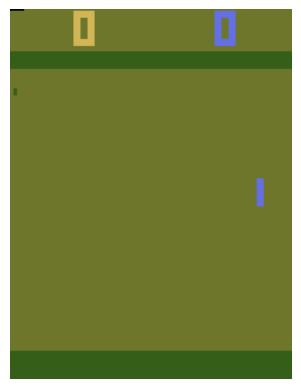

In [3]:
frame = env.reset()
img = env.render()  # returns an RGB array
plt.imshow(img)
plt.axis('off')
plt.show()

## 🧱 AtariPreprocessingWrapper: preprocesses frames and stacks them
- Converts RGB to grayscale
- Resizes to 84x84
- Stacks last 4 frames

In [4]:
class AtariPreprocessingWrapper(gym.Wrapper):
    def __init__(self, env, input_shape=(4, 84, 84)):
        super(AtariPreprocessingWrapper, self).__init__(env)
        self.input_shape = input_shape
        self.stacked_frames = np.zeros(self.input_shape, dtype=np.uint8)
        # Update the observation_space to match the preprocessed output
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=self.input_shape, dtype=np.uint8
        )

    def preprocess_frame(self, screen, exclude, output):
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        screen = cv2.resize(screen, (output, output), interpolation=cv2.INTER_AREA)
        screen = np.ascontiguousarray(screen, dtype=np.uint8)
        return screen

    def stack_frame(self, stacked_frames, frame, is_new):
        if is_new:
            stacked_frames = np.stack([frame] * 4, axis=0)
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame
        return stacked_frames

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        frame = self.preprocess_frame(state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=True)
        return self.stacked_frames, info

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        frame = self.preprocess_frame(next_state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=False)
        return self.stacked_frames, reward, terminated, truncated, info

## ✅ Wrap the environment and verify preprocessing output

In [5]:
env_ = AtariPreprocessingWrapper(env)

In [6]:
print(env_.observation_space)

Box(0, 255, (4, 84, 84), uint8)


In [7]:
# After resetting the environment
obs, info = env_.reset()
print("Shape:", obs.shape)        # Should be (4, 84, 84)
print("Dtype:", obs.dtype)        # Should be float32
print("Min/Max:", obs.min(), obs.max())  # Should be between 0.0 and 1.0

Shape: (4, 84, 84)
Dtype: uint8
Min/Max: 64 179


## 🖼️ Visualize stacked frames

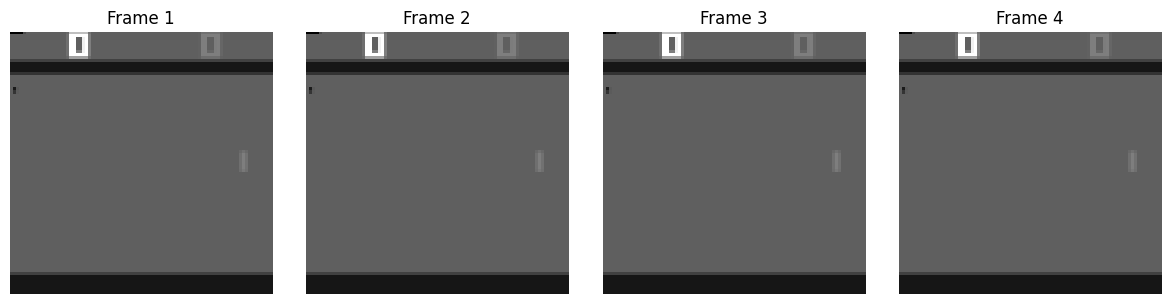

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(obs[i], cmap='gray')
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning using Optuna

In [ ]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def make_env():
    gym.register_envs(ale_py)
    env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")
    env = AtariPreprocessingWrapper(env)
    return env

def optimize_ppo(trial):
    env = make_env()
    eval_env = make_env()

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_categorical('n_steps', [128, 256, 512, 1024])
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 0.99)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
    ent_coef = trial.suggest_float('ent_coef', 1e-8, 1e-2, log=True)

    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        verbose=1,
        device="cuda"  # Enable this if using GPU
    )

    model.learn(total_timesteps=100_000)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=2)
    return mean_reward

# Start the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=10)

print("Best hyperparameters:", study.best_params)


[I 2025-06-25 14:29:09,751] A new study created in memory with name: no-name-79faf82c-122e-45ca-b7ba-fe83ee0efccc


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 155 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 256 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.017940674 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.232       |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0181      |
|    learning_rate        | 0.000117    |
|    loss                 | 0.0353      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0077     |
|    value_loss           | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2025-06-25 14:35:22,819] Trial 0 finished with value: -21.0 and parameters: {'learning_rate': 0.00011677344059985818, 'n_steps': 256, 'gamma': 0.9587441844357083, 'gae_lambda': 0.8777921470730469, 'clip_range': 0.23151208431514414, 'ent_coef': 0.00011307252882867835}. Best is trial 0 with value: -21.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 377 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 844          |
|    ep_rew_mean          | -19          |
| time/                   |              |
|    fps                  | 316          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0062591955 |
|    clip_fraction        | 0.0816       |
|    clip_range           | 0.145        |
|    entropy_loss         | -1.79        |
|    explained_variance   | -0.00406     |
|    learning_rate        | 0.000401     |
|    loss     

[I 2025-06-25 14:41:36,795] Trial 1 finished with value: -16.0 and parameters: {'learning_rate': 0.0004013191881325737, 'n_steps': 512, 'gamma': 0.9639452167810578, 'gae_lambda': 0.8274033895133379, 'clip_range': 0.1445217331955355, 'ent_coef': 2.177738835326187e-05}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 391 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 612           |
|    ep_rew_mean          | -21           |
| time/                   |               |
|    fps                  | 321           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00028573594 |
|    clip_fraction        | 0             |
|    clip_range           | 0.241         |
|    entropy_loss         | -1.79         |
|    explained_variance   | -0.00539      |
|    learning_rate        | 1.07e-05      

[I 2025-06-25 14:47:46,307] Trial 2 finished with value: -21.0 and parameters: {'learning_rate': 1.0710625290356293e-05, 'n_steps': 512, 'gamma': 0.9603927905620662, 'gae_lambda': 0.9513056564962502, 'clip_range': 0.24078025341840414, 'ent_coef': 1.7441870062148978e-08}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 711      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 397      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 722         |
|    ep_rew_mean          | -20         |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.003615525 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.115       |
|    entropy_loss  

[I 2025-06-25 14:53:59,075] Trial 3 finished with value: -21.0 and parameters: {'learning_rate': 9.737704407345521e-05, 'n_steps': 1024, 'gamma': 0.9225951719268555, 'gae_lambda': 0.8743239989452538, 'clip_range': 0.11484388414112552, 'ent_coef': 0.005587499889710052}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 395 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 797         |
|    ep_rew_mean          | -20         |
| time/                   |             |
|    fps                  | 322         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.015722893 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.235       |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.0128     |
|    learning_rate        | 4.32e-05    |
|    loss                 | 0.

[I 2025-06-25 15:00:07,141] Trial 4 finished with value: -21.0 and parameters: {'learning_rate': 4.3236649230794157e-05, 'n_steps': 512, 'gamma': 0.9406321580398679, 'gae_lambda': 0.8231636883935916, 'clip_range': 0.23548071279989835, 'ent_coef': 0.0016961116672533875}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 843      |
|    ep_rew_mean     | -19      |
| time/              |          |
|    fps             | 376      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 814         |
|    ep_rew_mean          | -19         |
| time/                   |             |
|    fps                  | 316         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008613995 |
|    clip_fraction        | 0           |
|    clip_range           | 0.217       |
|    entropy_loss  

[I 2025-06-25 15:06:15,936] Trial 5 finished with value: -21.0 and parameters: {'learning_rate': 2.76521896716131e-05, 'n_steps': 1024, 'gamma': 0.9861964892288216, 'gae_lambda': 0.8366034847588224, 'clip_range': 0.21701320173979932, 'ent_coef': 1.5373059525411305e-08}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 394 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 329          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0009857197 |
|    clip_fraction        | 0            |
|    clip_range           | 0.227        |
|    entropy_loss         | -1.79        |
|    explained_variance   | 0.00784      |
|    learning_rate        | 4.46e-05     |
|    loss                 | 0.0258       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0041      |
|    value_los

[I 2025-06-25 15:12:18,898] Trial 6 finished with value: -21.0 and parameters: {'learning_rate': 4.464632744858413e-05, 'n_steps': 128, 'gamma': 0.9755305045039593, 'gae_lambda': 0.9422517358793921, 'clip_range': 0.22687083597156868, 'ent_coef': 5.172914445716745e-07}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 398 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 641         |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.025346316 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.271       |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.000235   |
|    learning_rate        | 0.000464    |
|    loss                 | 0.

[I 2025-06-25 15:18:32,584] Trial 7 finished with value: -17.5 and parameters: {'learning_rate': 0.0004639192239536669, 'n_steps': 512, 'gamma': 0.9014619087393965, 'gae_lambda': 0.986477050931982, 'clip_range': 0.2709258073301618, 'ent_coef': 1.2764310738960555e-05}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 690      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 395      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 662         |
|    ep_rew_mean          | -20.7       |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.014772271 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.214       |
|    entropy_loss  

[I 2025-06-25 15:24:45,976] Trial 8 finished with value: -16.0 and parameters: {'learning_rate': 0.00012121985152686752, 'n_steps': 1024, 'gamma': 0.9309884418389816, 'gae_lambda': 0.8954247915050677, 'clip_range': 0.21355790602856178, 'ent_coef': 1.5974691479705305e-06}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 391 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 697         |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 322         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.026726864 |
|    clip_fraction        | 0.0414      |
|    clip_range           | 0.242       |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.0123      |
|    learning_rate        | 7.19e-05    |
|    loss                 | 0.

[I 2025-06-25 15:30:54,871] Trial 9 finished with value: -21.0 and parameters: {'learning_rate': 7.190882041570484e-05, 'n_steps': 512, 'gamma': 0.9943743011964942, 'gae_lambda': 0.8799451186176211, 'clip_range': 0.24159821574039902, 'ent_coef': 0.00028639176468642284}. Best is trial 1 with value: -16.0.


Best hyperparameters: {'learning_rate': 0.0004013191881325737, 'n_steps': 512, 'gamma': 0.9639452167810578, 'gae_lambda': 0.8274033895133379, 'clip_range': 0.1445217331955355, 'ent_coef': 2.177738835326187e-05}


## Using the Best Parameters

In [10]:
from stable_baselines3 import PPO

# Use your best hyperparameters from Optuna
model_PPO = PPO(
    "CnnPolicy",
    env_,
    learning_rate=0.0004013191881325737,
    n_steps=512,
    gamma=0.9639452167810578,
    gae_lambda=0.8274033895133379,
    clip_range=0.1445217331955355,
    ent_coef=2.177738835326187e-05,
    verbose=1,
    tensorboard_log="./tensorboard_log"
)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/PPO_1
----------------------------
| time/              |     |
|    fps             | 390 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 683          |
|    ep_rew_mean          | -21          |
| time/                   |              |
|    fps                  | 325          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0057052486 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.145        |
|    entropy_loss         | -1.79        |
|    explained_variance   | -0.00602     |
|    learning_rate    

NameError: name 'run_episodes_get_rewards' is not defined

## 🏁 Evaluate best PPO

In [11]:
def run_episodes_get_rewards(model, env, n_episodes=10):
    episode_rewards = []
    for episode in range(n_episodes):
        obs, info = env.reset()  
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}")
    return episode_rewards

In [12]:
# Evaluate
episodes = 1000
rewards_ppo = run_episodes_get_rewards(model_PPO, env_, n_episodes=episodes)

Episode 1: Reward = -4.00
Episode 2: Reward = -12.00
Episode 3: Reward = -11.00
Episode 4: Reward = -13.00
Episode 5: Reward = -3.00
Episode 6: Reward = -11.00
Episode 7: Reward = -11.00
Episode 8: Reward = -8.00
Episode 9: Reward = -9.00
Episode 10: Reward = -11.00
Episode 11: Reward = -17.00
Episode 12: Reward = -11.00
Episode 13: Reward = -15.00
Episode 14: Reward = -10.00
Episode 15: Reward = -13.00
Episode 16: Reward = -9.00
Episode 17: Reward = -10.00
Episode 18: Reward = -14.00
Episode 19: Reward = -12.00
Episode 20: Reward = -11.00
Episode 21: Reward = -14.00
Episode 22: Reward = -13.00
Episode 23: Reward = -10.00
Episode 24: Reward = -10.00
Episode 25: Reward = -8.00
Episode 26: Reward = -9.00
Episode 27: Reward = -10.00
Episode 28: Reward = -6.00
Episode 29: Reward = -8.00
Episode 30: Reward = -16.00
Episode 31: Reward = -3.00
Episode 32: Reward = -9.00
Episode 33: Reward = -8.00
Episode 34: Reward = -10.00
Episode 35: Reward = -7.00
Episode 36: Reward = -8.00
Episode 37: Rew

## 📈 Plot rewards for DQN

In [13]:
def plot_rewards(reward_list, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(reward_list, label='Reward per Episode')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

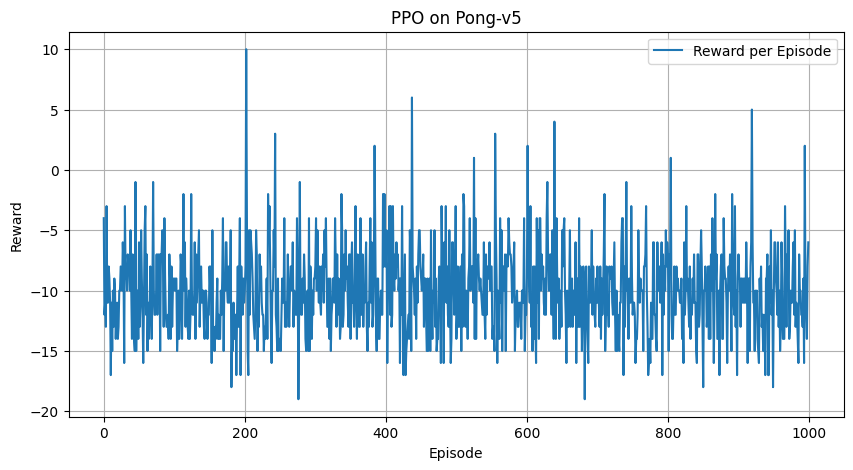

In [14]:
plot_rewards(rewards_ppo, "PPO on Pong-v5")

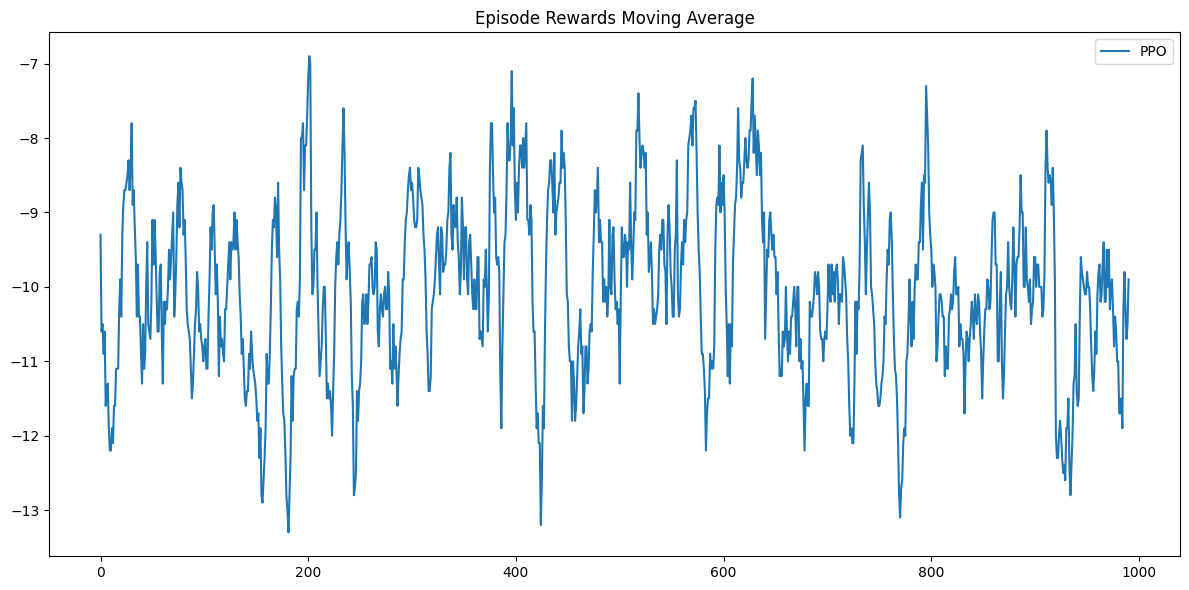

In [16]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot smoothed rewards
plt.figure(figsize=(12, 6))
plt.title("Episode Rewards Moving Average")
plt.plot(moving_average(rewards_ppo), label="PPO")
plt.legend()
plt.tight_layout()
plt.show()